In [ ]:
%load_ext autoreload
%autoreload 2

In [1]:
# !pip install --upgrade nbformat


In [22]:
%matplotlib inline


In [1]:
!pip install umap-learn[plot]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 65.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 86.7 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 77.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 63.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 8.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.3/87.3 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 973.1/973.1 kB 41.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 65.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 91.3 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 kB 11.1 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.1/52.1 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.1/160.1 kB 17.9 MB/s eta 0:00:00
  Created wheel for datashape: filename=datashape-0.5.2-py3-none-any.whl size=59421 sha256=6f67ef4aa51a3906c42cb3a17289eae2991cc0992e1a8f14e811687189db71e5
  Stored in directory: /root/.cache/pip/wheels/6d/79/c4/c425774559165f472d32e5ef592ff9a71179abb31f05dbc98b
Successfully built datashape
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 4.11.4
    Uninstalling importlib-metadata-4.11.4:
      Successfully uninstalled importlib-metadata-4.11.4
  Attempting uninstall: bokeh
    Found existing installation: bokeh 3.1.0
    Uninstalling bokeh-3.1.0:
      Successfully uninstalled bokeh-3.1.0


In [21]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""
import umap.plot
import umap.umap_ as umap
from collections import defaultdict
import matplotlib.pyplot as plt
from ml4h.explorations import latent_space_dataframe,stratify_and_project_latent_space,plot_nested_dictionary,iterative_subspace_removal

In [4]:
#code to copy files from google cloud
# !gsutil cp gs://fc-e5ea247f-18af-45e4-825a-71f0537e3cb7/hidden_ecg_rest_median_raw_10_dropout_pair_contrastive_lax_4ch_cycle_ecg_median_10_pretrained_256d_v2020_06_07.tsv latent_file.tsv
    

# !gsutil cp gs://fc-e5ea247f-18af-45e4-825a-71f0537e3cb7/tensors_all_union.csv tensors_all_union.csv
    
# !gsutil cp gs://fc-e5ea247f-18af-45e4-825a-71f0537e3cb7/hidden_lax_4ch_heart_center_dropout_pair_contrastive_lax_4ch_cycle_ecg_median_10_pretrained_256d_v2020_06_07.tsv latent_file_for_comparison.tsv

In [9]:
# Loading file path from local dir, gsutil cp was not working but you can try gsutil
ml4h_dir = os.path.dirname(os.getcwd())
latent_file = os.path.join(ml4h_dir,"latent_data_test/latent_file.tsv")
latent_file_for_comparison = os.path.join(ml4h_dir,"latent_data_test/latent_file_for_comparison.tsv")
label_file = os.path.join(ml4h_dir,"latent_data_test/tensors_all_union.csv") 

In [10]:
# defining categorical and continuous covariates variables
categorical_covariates = ['Sex_Male_0_0',
 'atrial_fibrillation_or_flutter',
 'coronary_artery_disease',
 'diabetes_type_2',
 'hypercholesterolemia',
 'hypertension',
 'Sinus_bradycardia',
 'Marked_sinus_bradycardia',
 'Other_sinus_rhythm']

continuous_covariates = ['age', 'bmi', 'RRInterval', 'QTInterval', 'LVM', 'RVEDV', 'PC1', 'PC2', 'PC3']

all_scores = defaultdict(dict)


In [11]:
continuous_covariates

['age', 'bmi', 'RRInterval', 'QTInterval', 'LVM', 'RVEDV', 'PC1', 'PC2', 'PC3']

In [12]:
#renaming columns of latent file
col_rename = {f'22009_Genetic-principal-components_0_{i}': f'PC{i}' for i in range(1,41)}
col_rename['Genetic-sex_Male_0_0'] = 'sex'
col_rename['21003_Age-when-attended-assessment-centre_2_0'] = 'age'
col_rename['21001_Body-mass-index-BMI_2_0'] = 'bmi'

# ECG Inferences from contrasive paired model

In [23]:
latent_df = latent_space_dataframe(latent_file, label_file)
latent_df = latent_df.rename(columns=col_rename)
latent_df.head(5)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,latent_246,latent_247,latent_248,latent_249,latent_250,latent_251,latent_252,latent_253,latent_254,latent_255
0,-13.040499,5.09869,-0.941436,1.10853,-1.113140,-0.551117,0.108314,0.384301,-1.836240,0.841757,...,0.357947,0.572839,-0.151002,-0.141661,-0.005667,-0.119862,-0.850965,-0.756585,-0.147475,-0.007641
1,-16.290900,1.73394,-3.384810,2.69792,0.750705,-1.378500,-3.941310,-2.645830,3.677180,1.559660,...,-0.120125,-0.580071,-0.149421,-0.140083,-0.004279,0.092604,0.947224,0.245169,-0.145886,-0.006162
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.308097,1.045822,-0.201392,-0.191949,-0.049913,0.289472,-0.622445,0.984579,-0.198128,-0.054796
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.501217,-0.023139,-0.136885,-0.127572,0.006729,-0.030844,0.685641,0.009245,-0.133284,0.005570
4,-11.620700,5.15124,-1.085570,-2.52474,-2.436100,-1.334970,1.850050,1.236000,-0.165032,-2.820240,...,0.368554,0.684087,-0.157703,-0.148348,-0.011551,-0.086389,-0.356414,-0.425291,-0.154212,-0.013912


In [24]:
latent_dimension = 256
latent_cols = [f'latent_{i}' for i in range(latent_dimension)]
for c in categorical_covariates:
    all_scores['DropFuse ECG'].update(stratify_and_project_latent_space(c, 1, 0, latent_cols, latent_df))
for c in continuous_covariates:
    all_scores['DropFuse ECG'].update(stratify_and_project_latent_space(c, latent_df[c].median(), 
                                                                        0, latent_cols, latent_df))
all_scores    

defaultdict(dict,
            {'DropFuse ECG': {'Sex_Male_0_0': (246.3248734259481, 0.0, 19109),
              'atrial_fibrillation_or_flutter': (27.56523383457332,
               4.027403468739663e-135,
               1401),
              'coronary_artery_disease': (31.267748705156492,
               1.2919445953133211e-165,
               1384),
              'diabetes_type_2': (38.70931898791368,
               8.041922372769419e-241,
               1670),
              'hypercholesterolemia': (46.87947117180172, 0.0, 8661),
              'hypertension': (66.54679094405562, 0.0, 12171),
              'Sinus_bradycardia': (110.43796999487327, 0.0, 13865),
              'Marked_sinus_bradycardia': (116.86075643835986, 0.0, 3773),
              'Other_sinus_rhythm': (37.268778812797585,
               5.219791266375579e-249,
               2627),
              'age': (53.88417825814016, 0.0, 19960),
              'bmi': (119.5071468018633, 0.0, 19004),
              'RRInterval': (184.

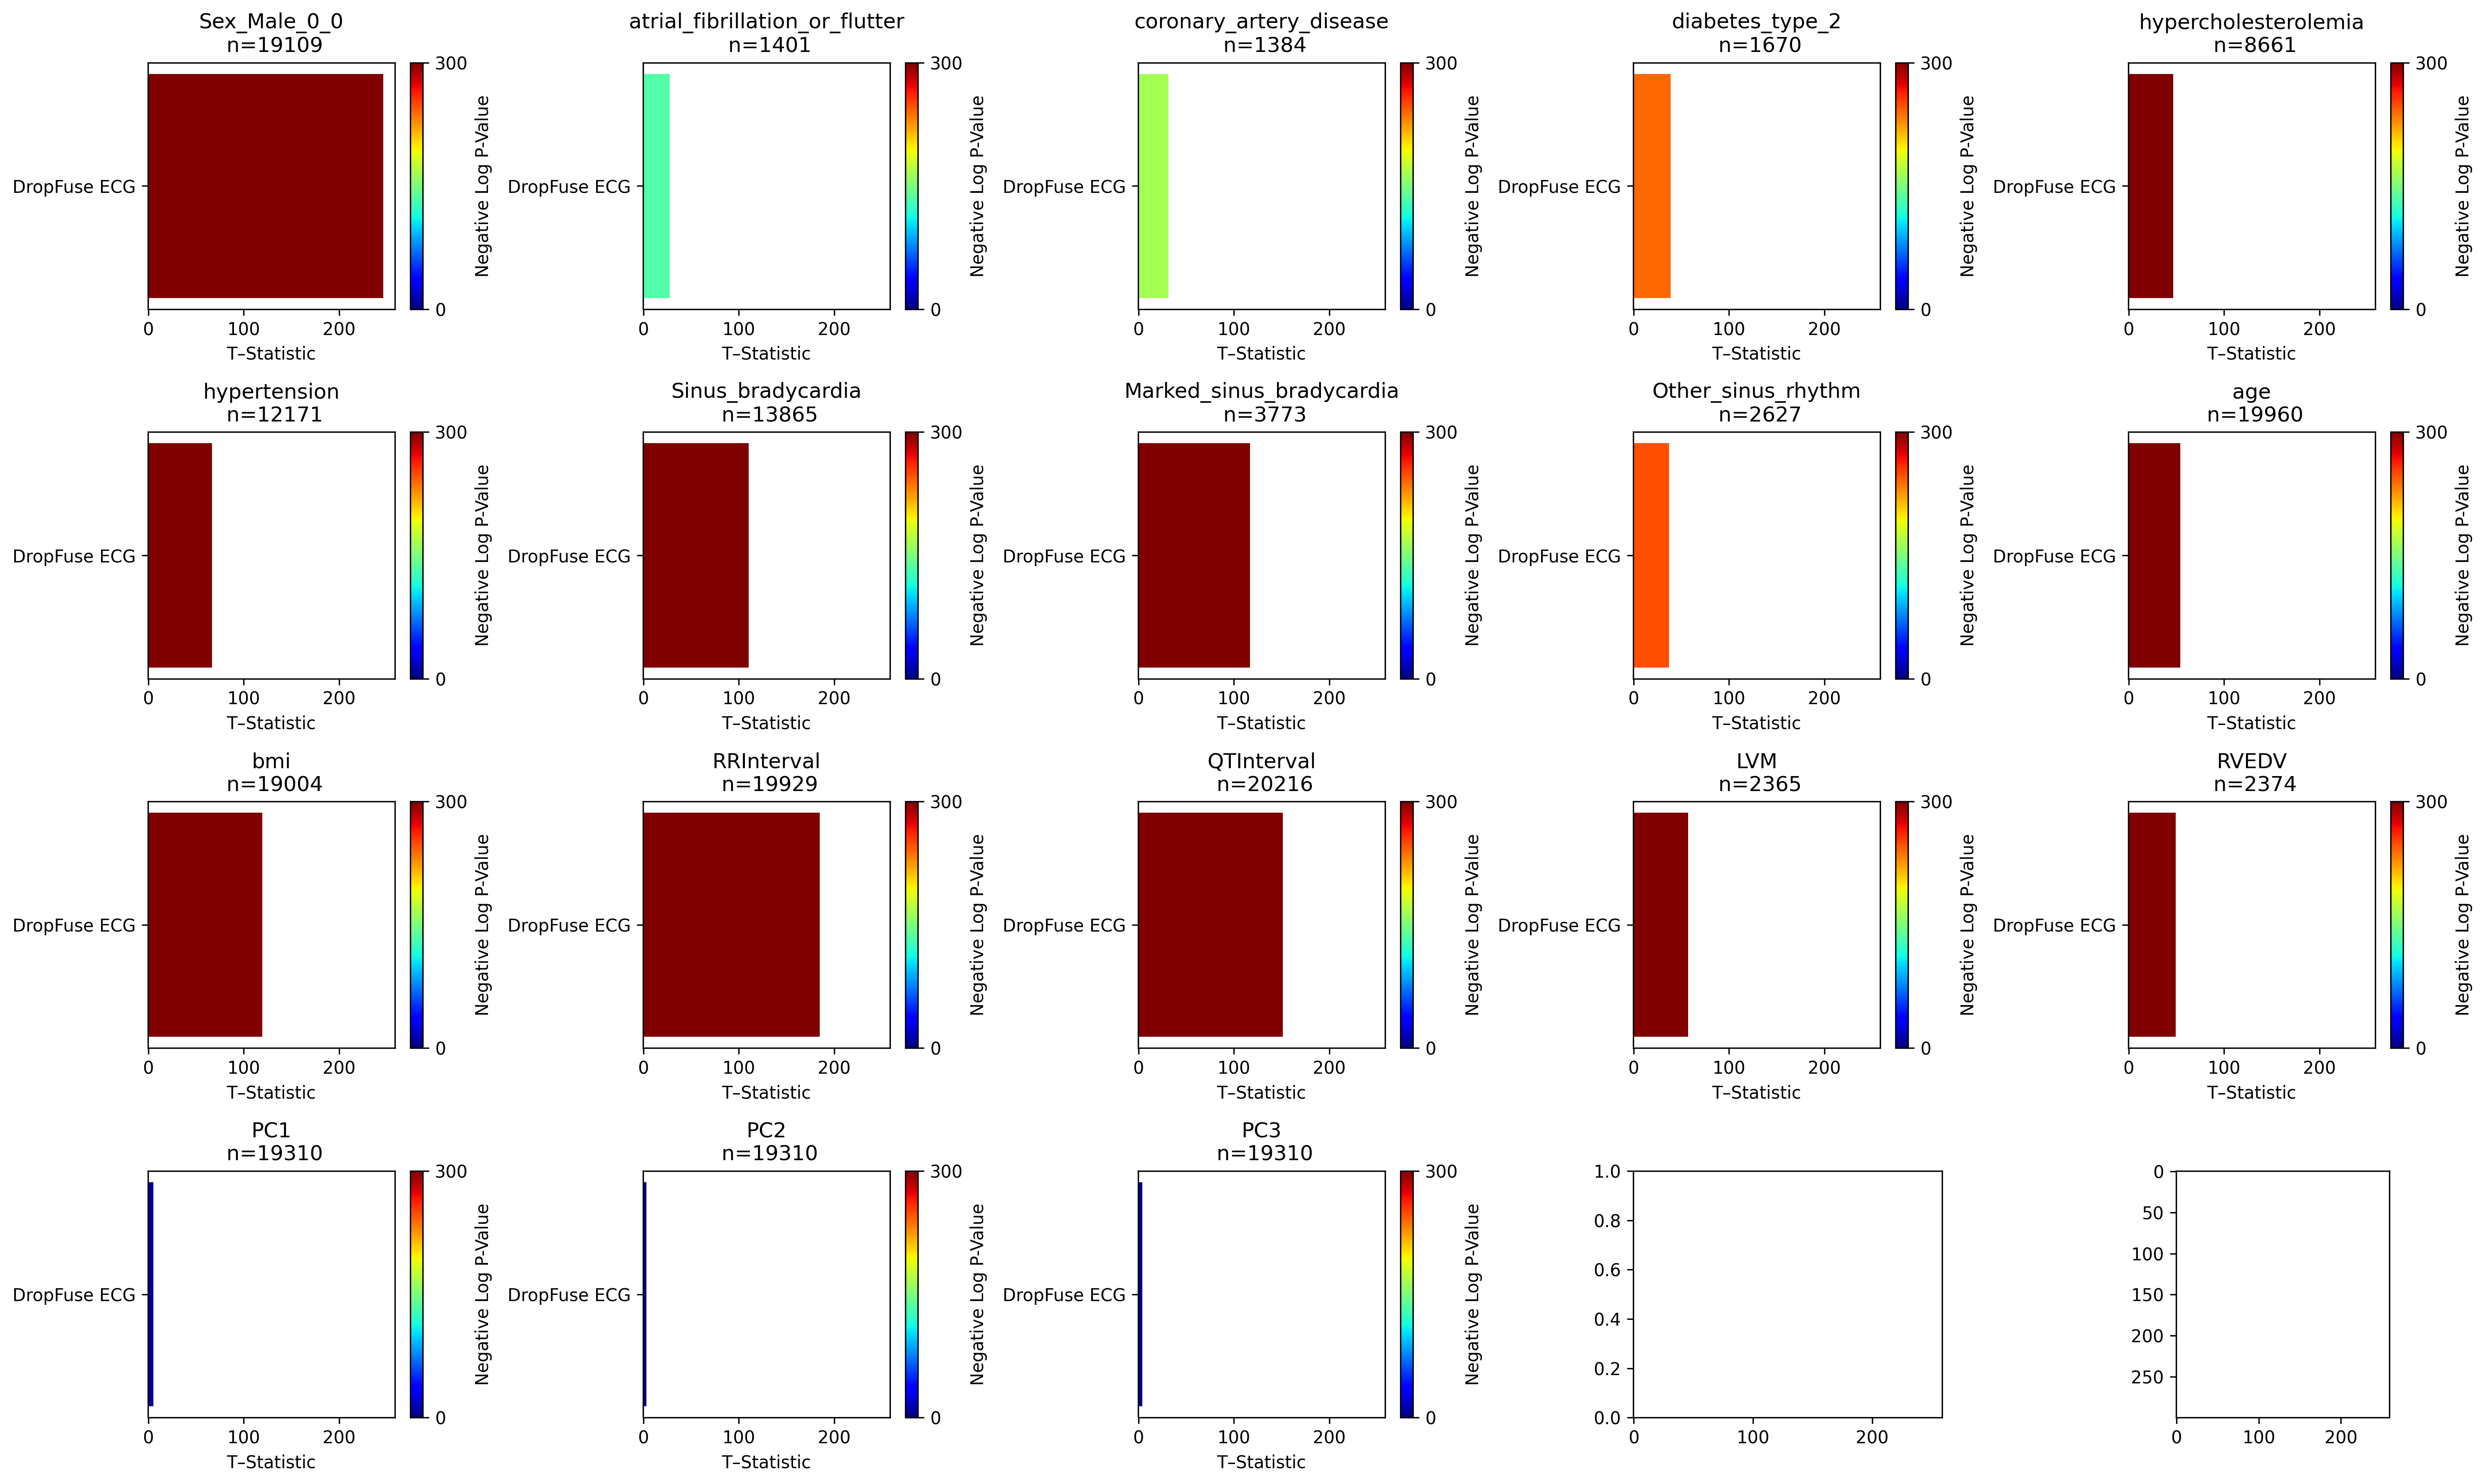

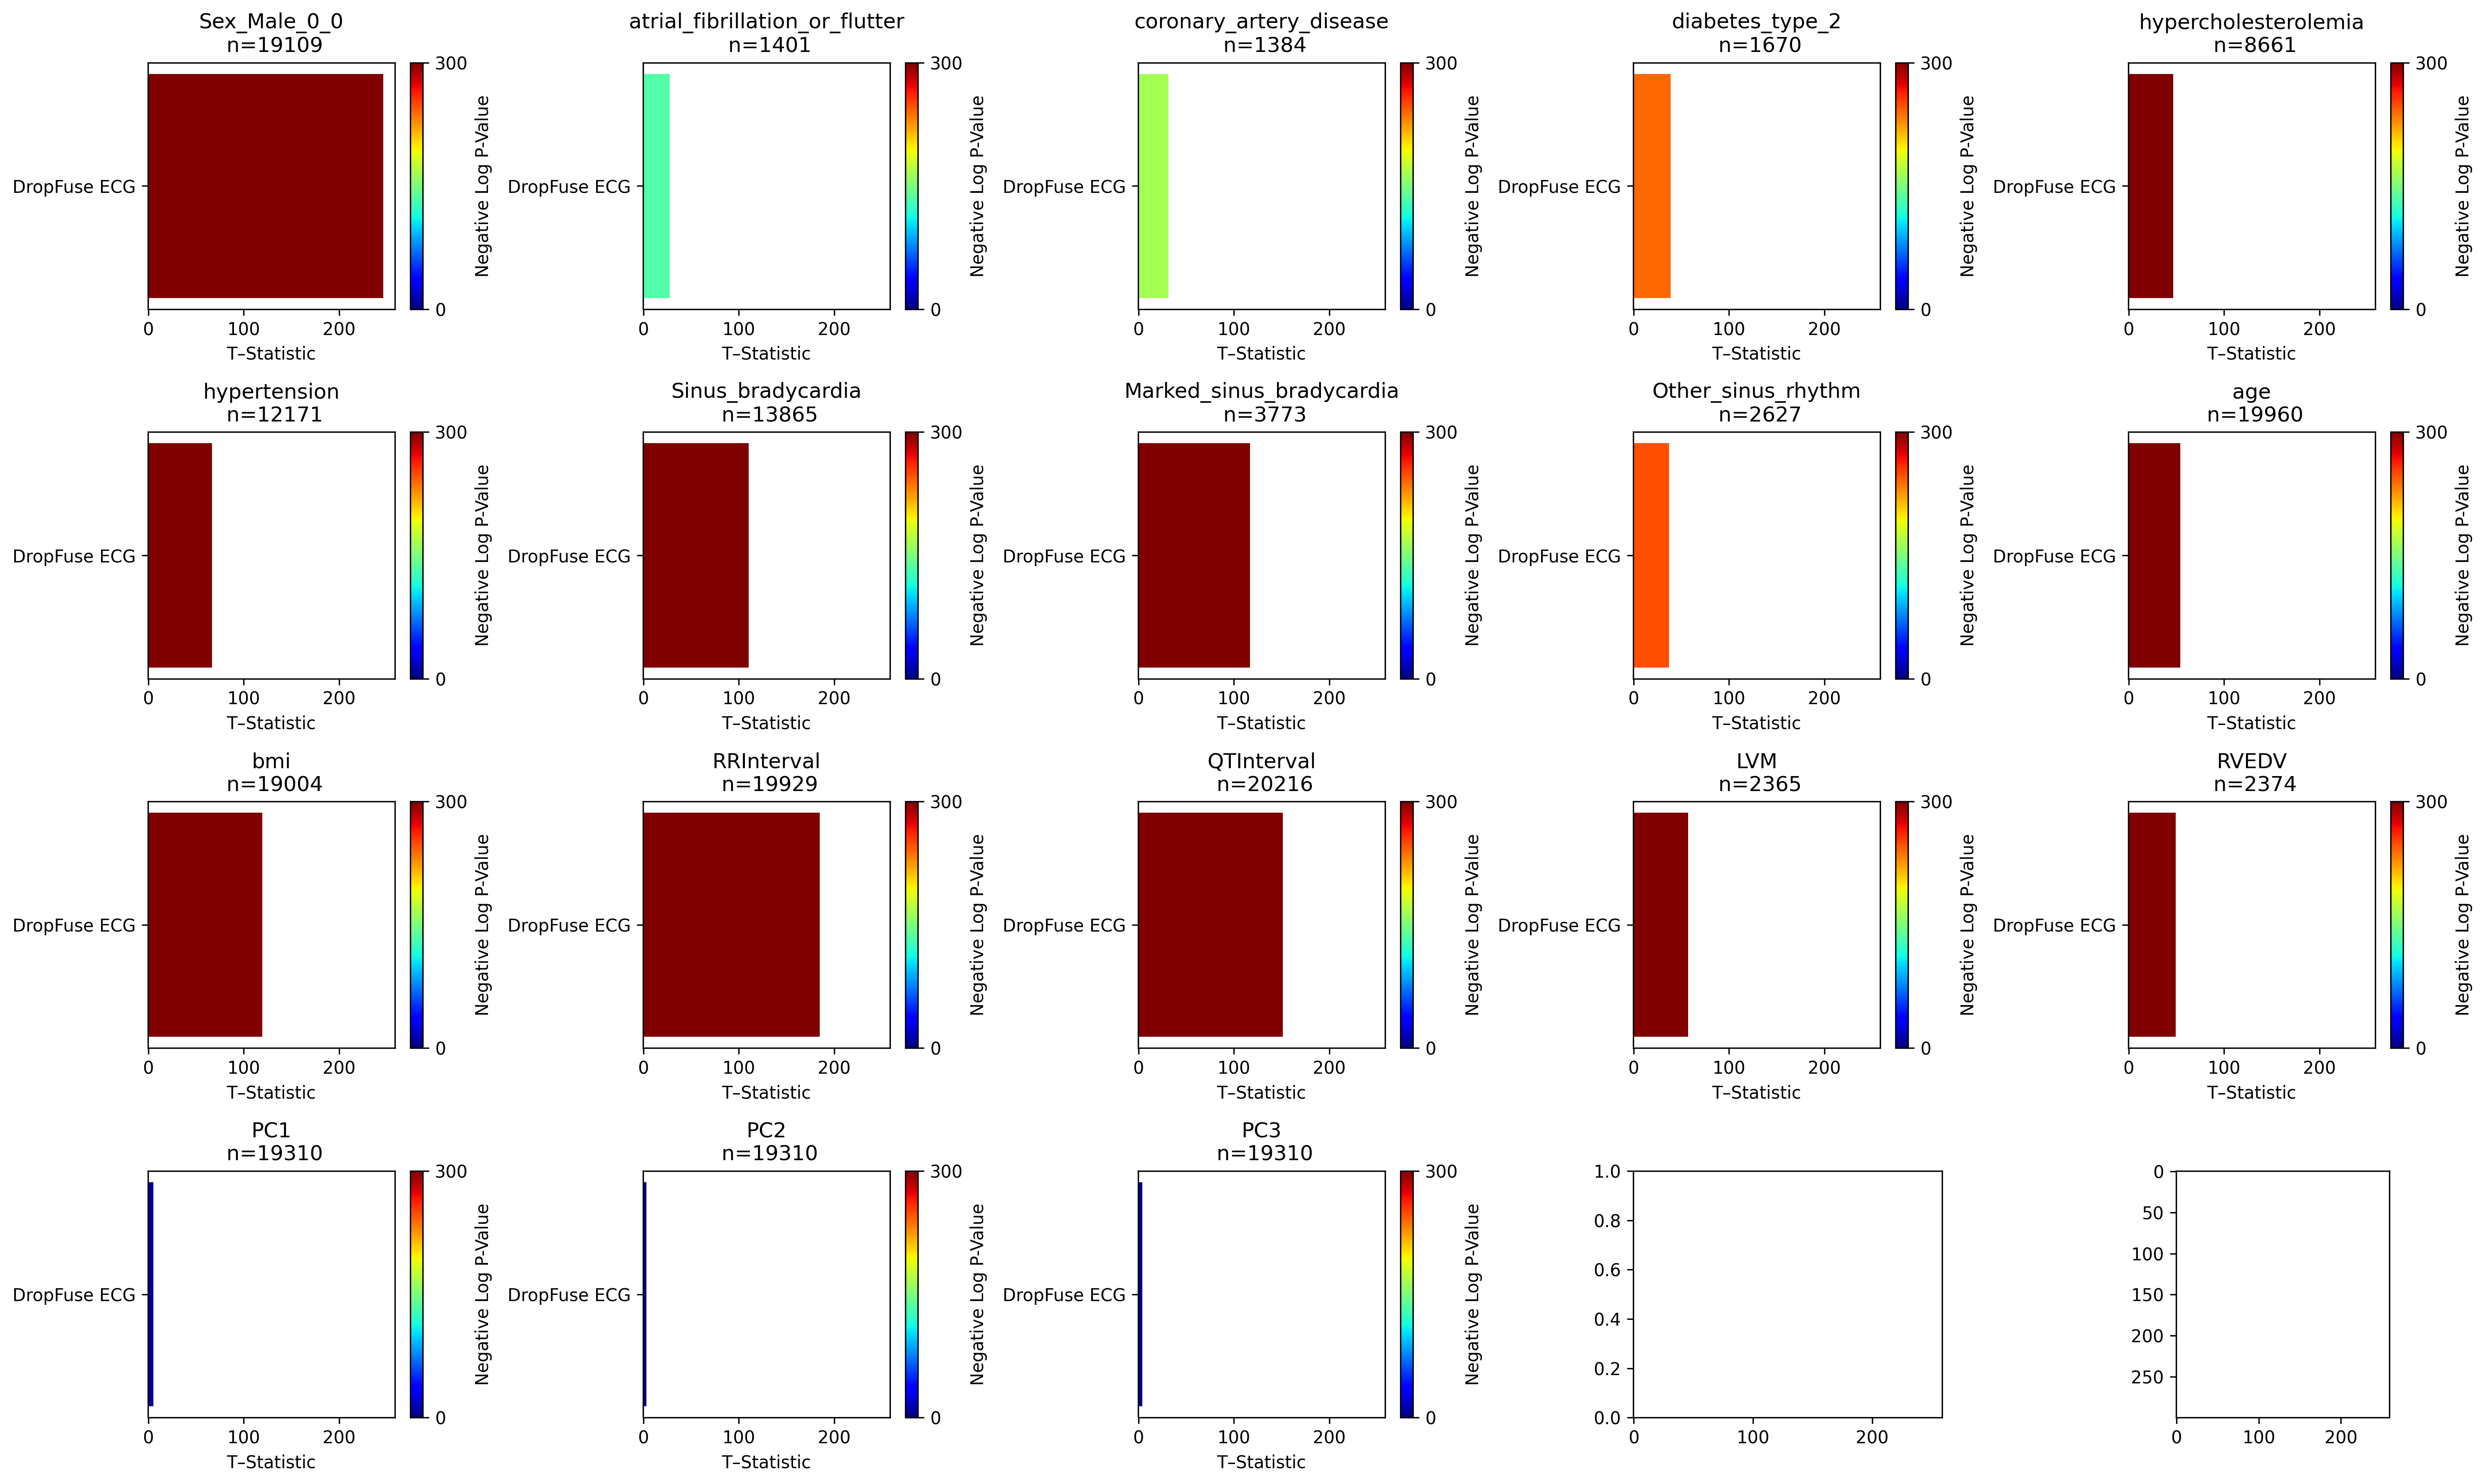

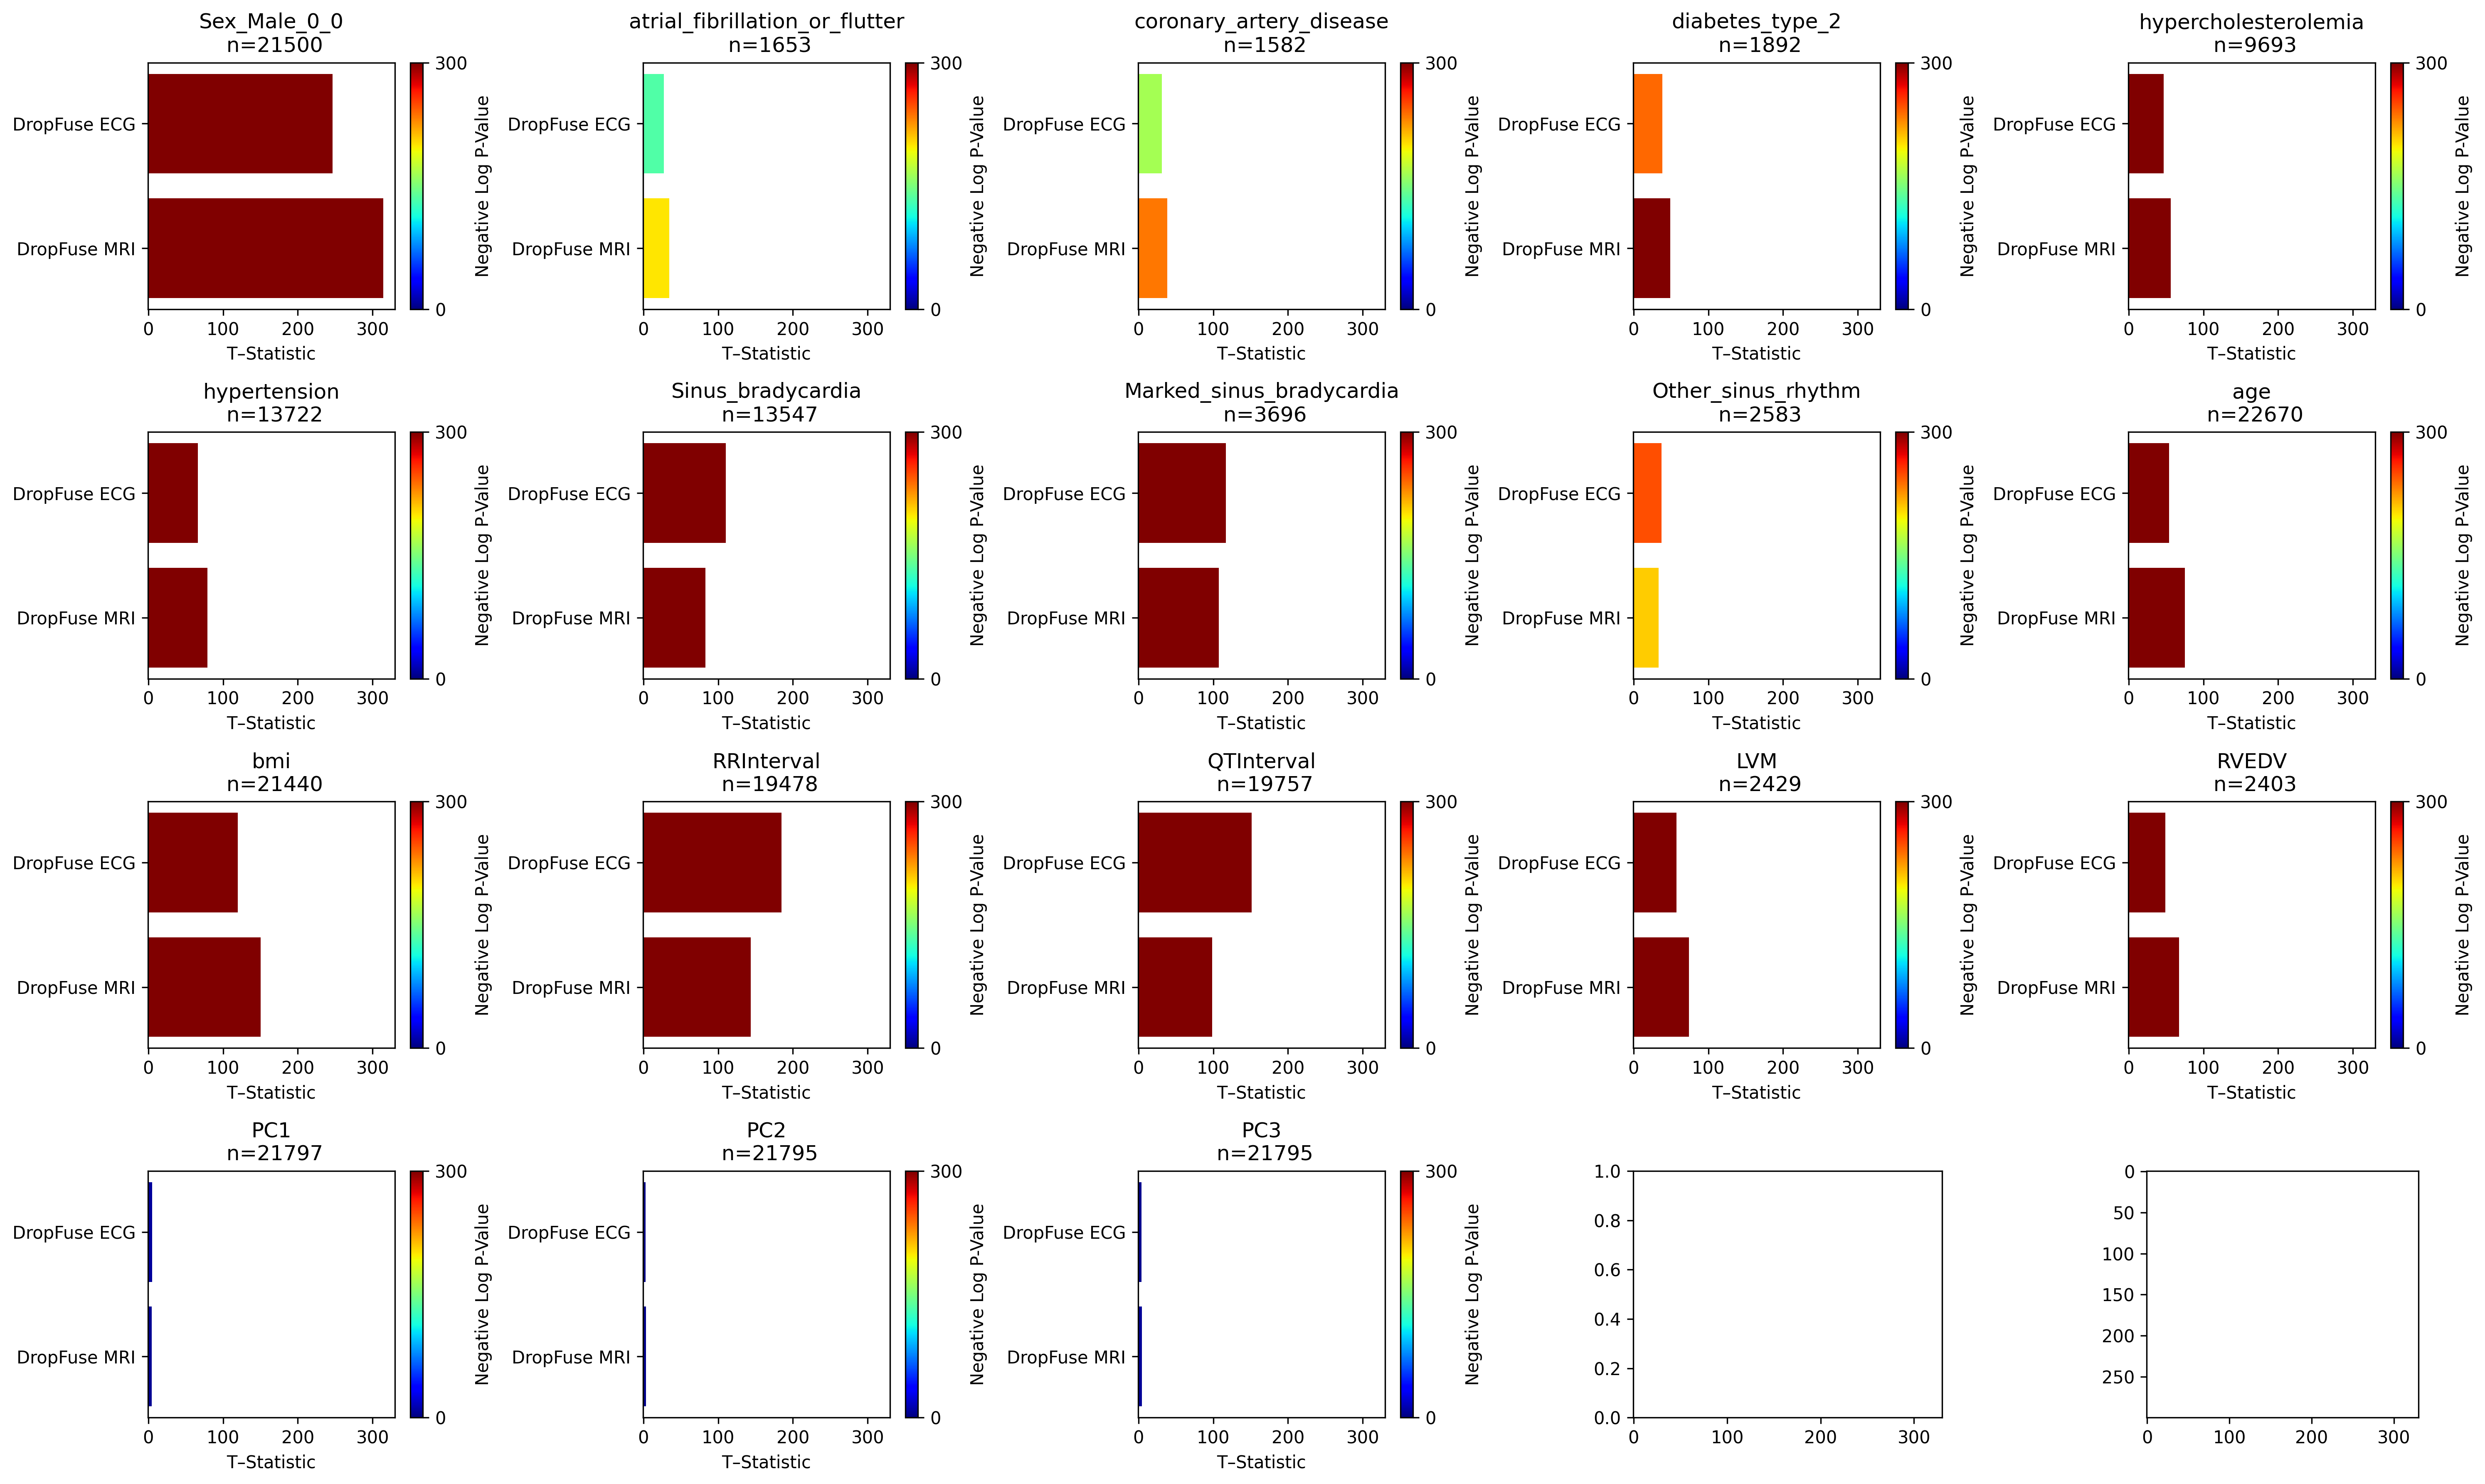

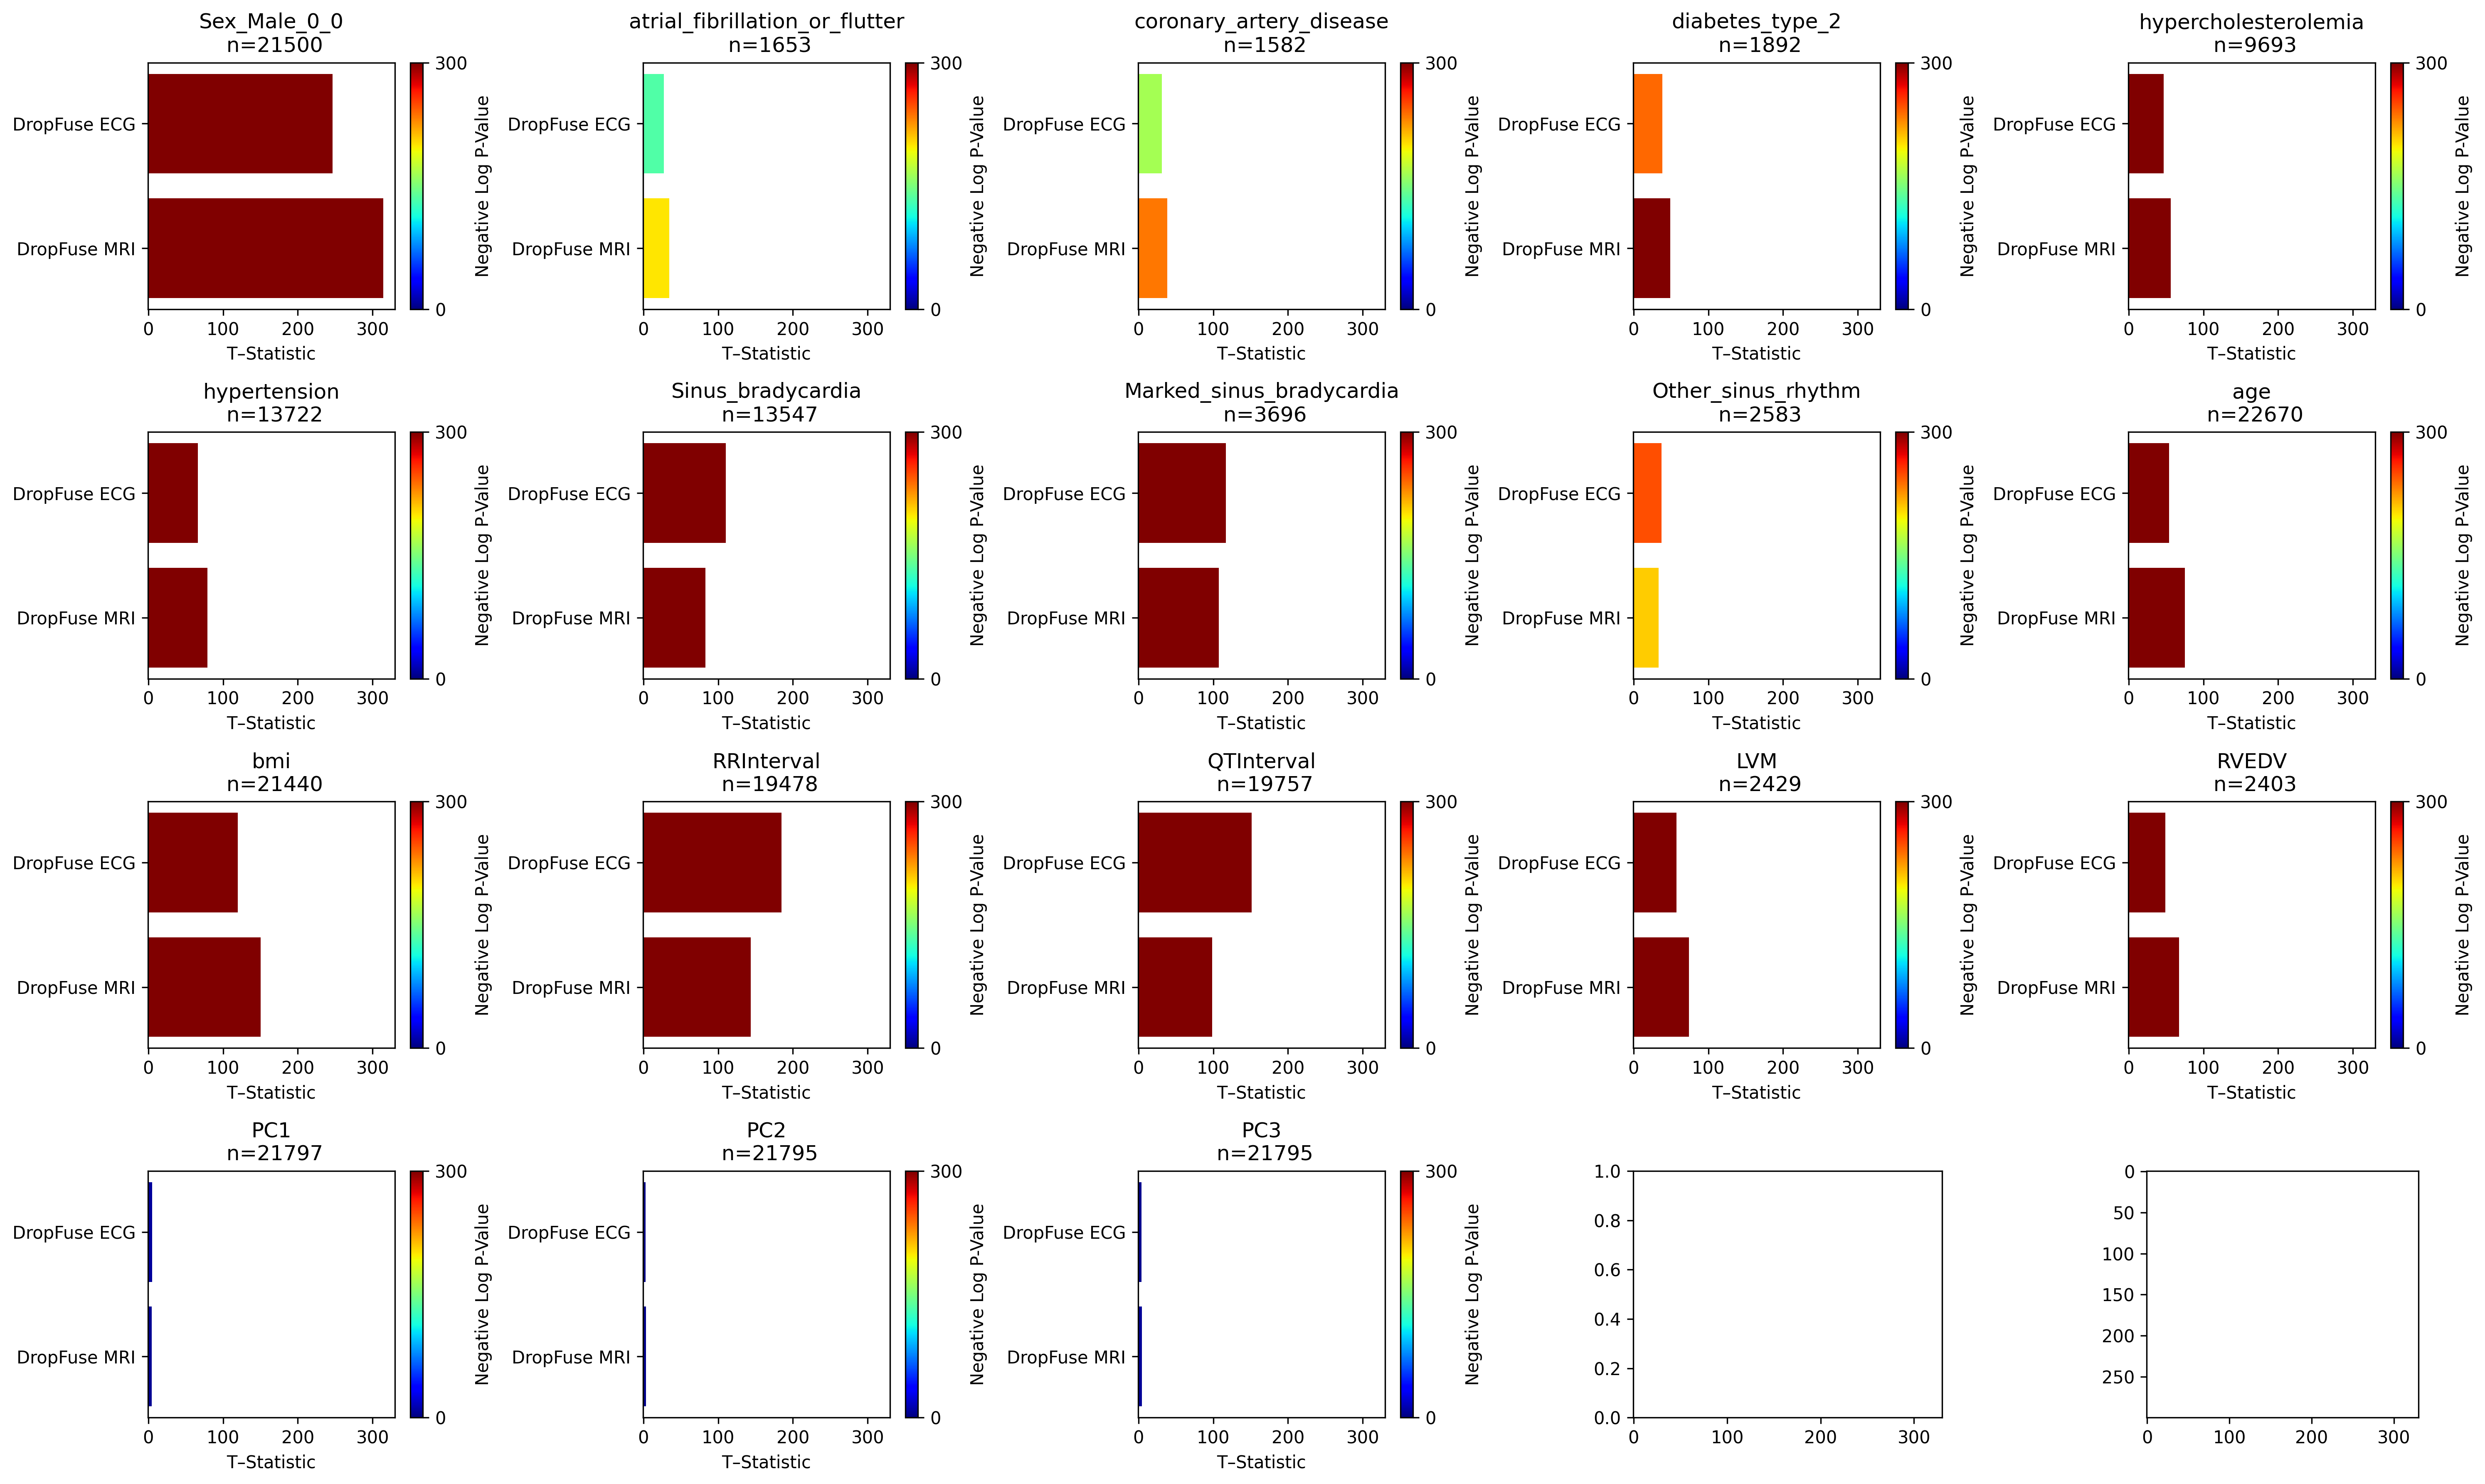

In [25]:
plot_nested_dictionary(all_scores)

# MRI Inferences from contrasive paired model

In [26]:
# loading latent space file
latent_df = latent_space_dataframe(latent_file_for_comparison, label_file)
latent_dimension = 256
latent_cols = [f'latent_{i}' for i in range(latent_dimension)]
latent_df = latent_df.rename(columns=col_rename)
for c in categorical_covariates:
    all_scores['DropFuse MRI'].update(stratify_and_project_latent_space(c, 1, 0, latent_cols, latent_df))
for c in continuous_covariates:
    all_scores['DropFuse MRI'].update(stratify_and_project_latent_space(c, latent_df[c].median(), 
                                                                        0, latent_cols, latent_df))


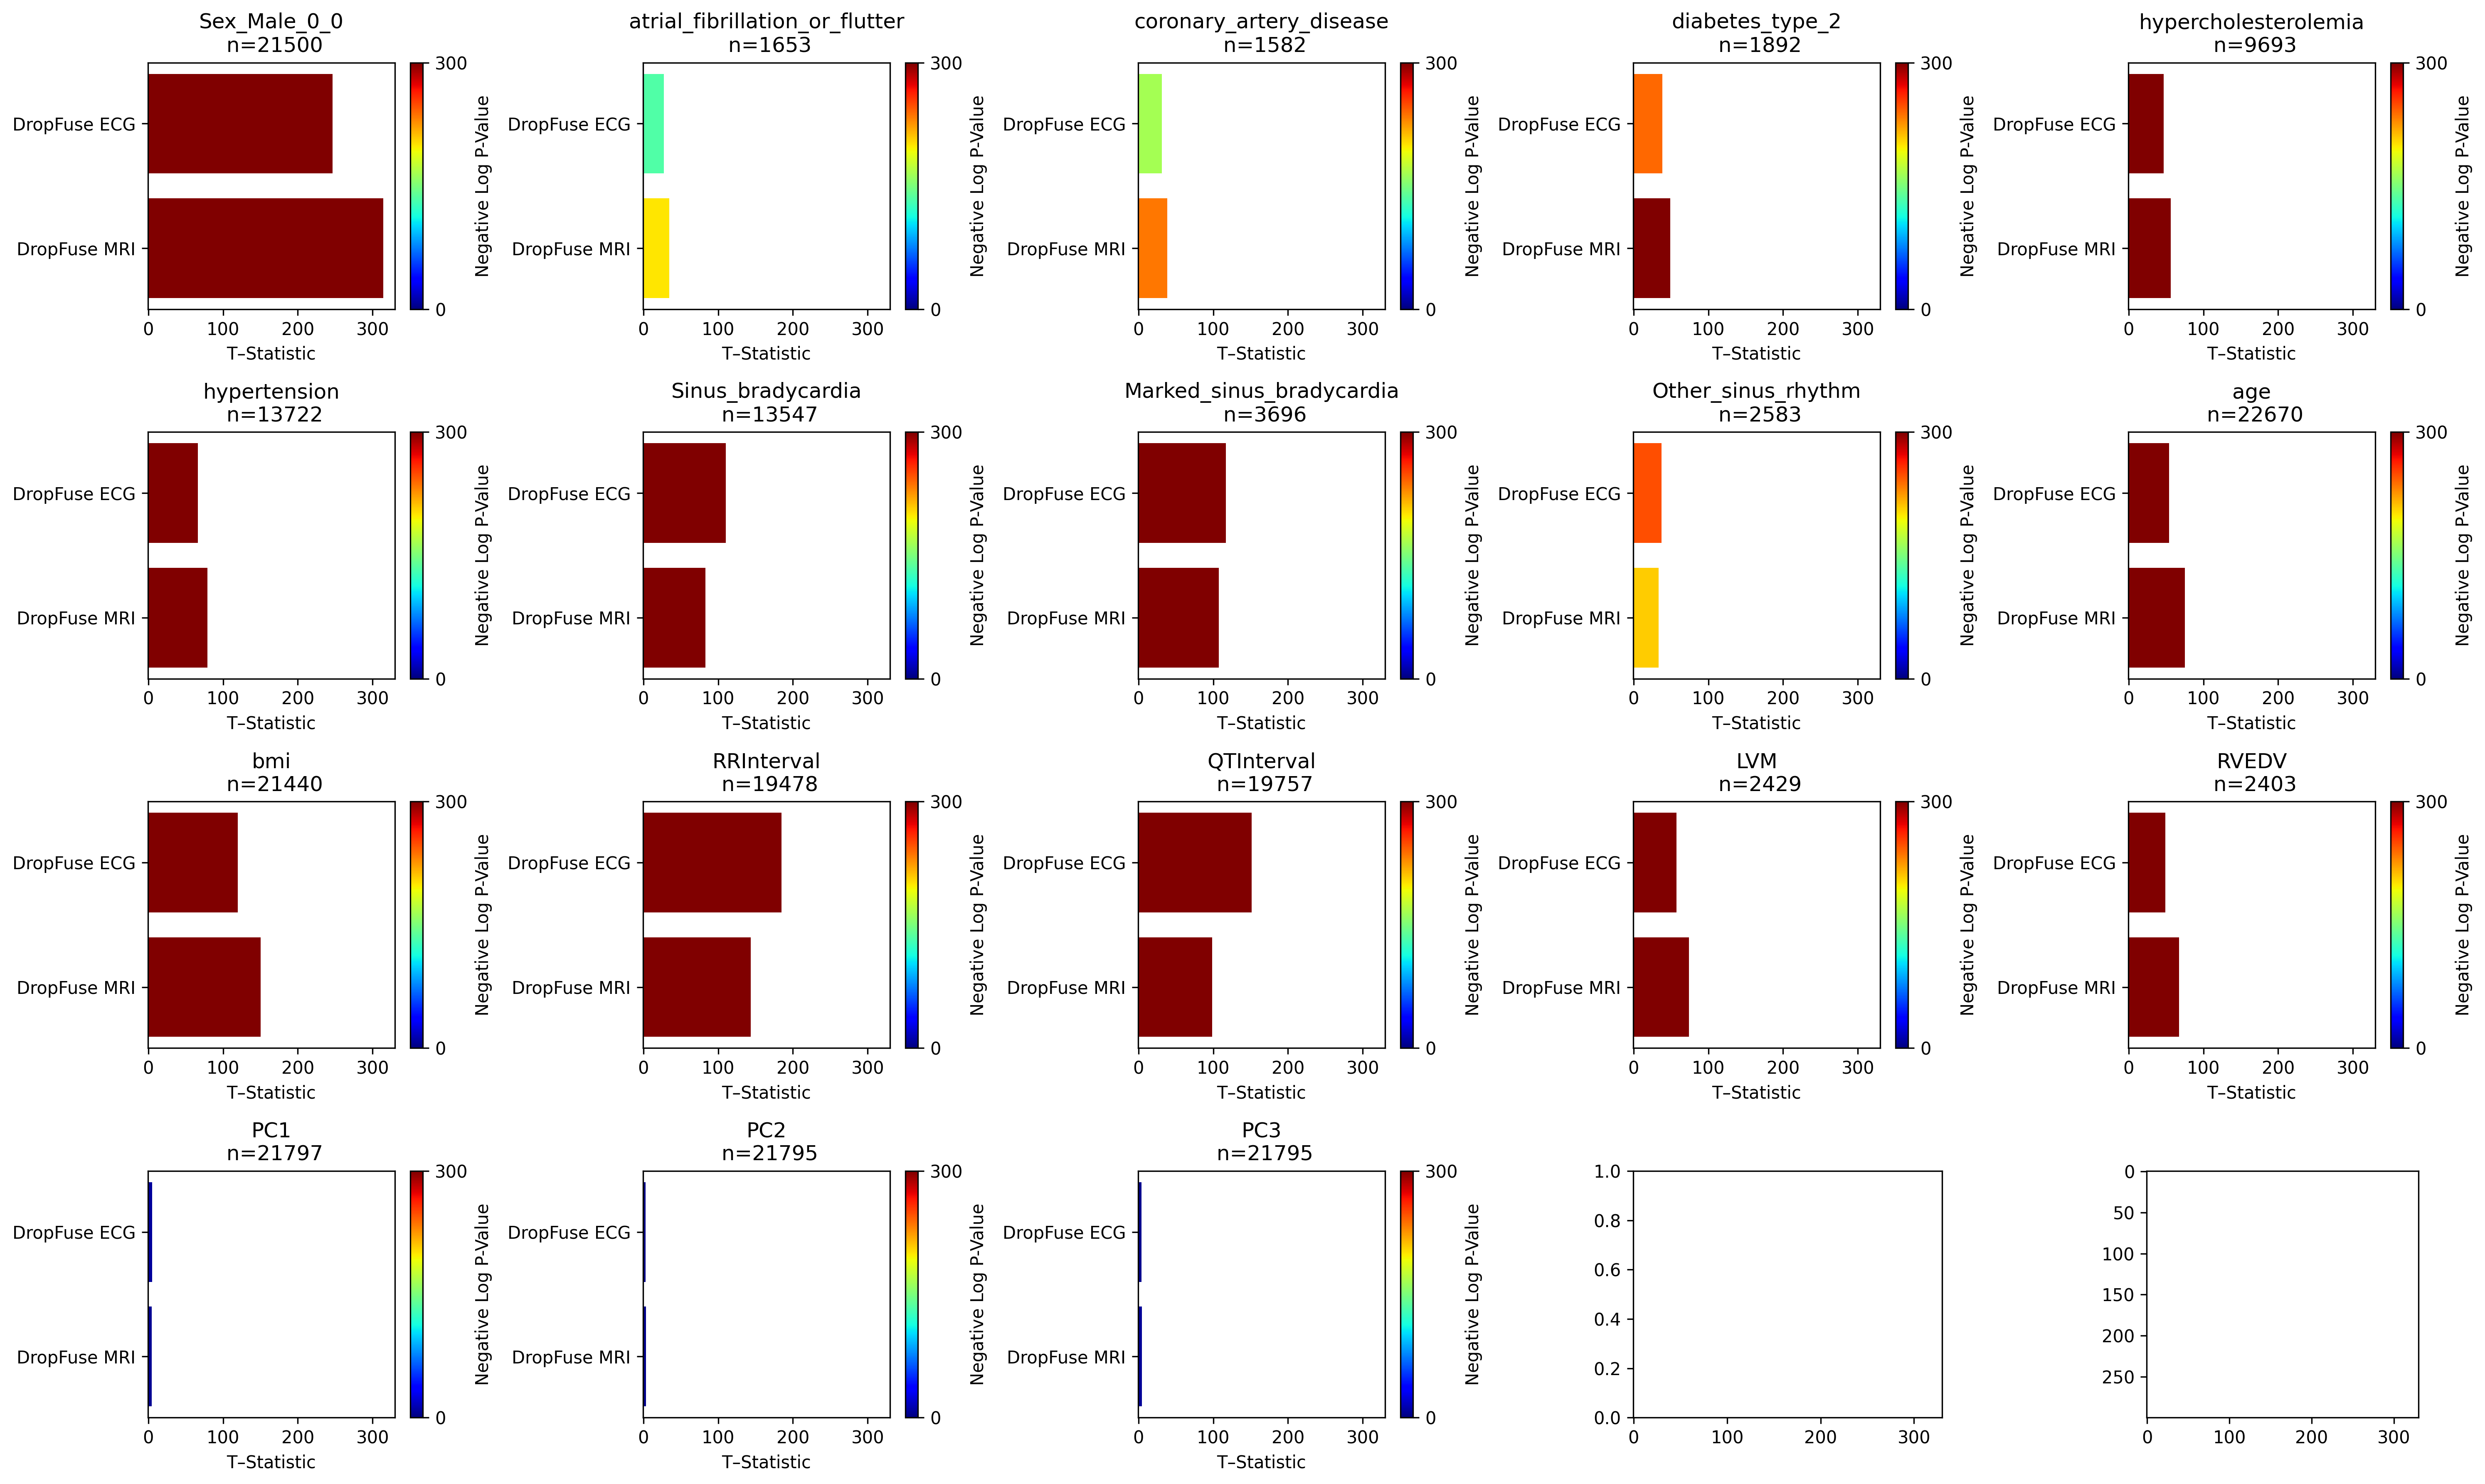

In [27]:
plot_nested_dictionary(all_scores)

In [28]:
space = latent_df[latent_cols].to_numpy()
umapped = umap.UMAP().fit_transform(space)
print(umapped.shape)
print(latent_df['Sex_Male_0_0'].to_numpy().shape)

(44643, 2)
(44643,)


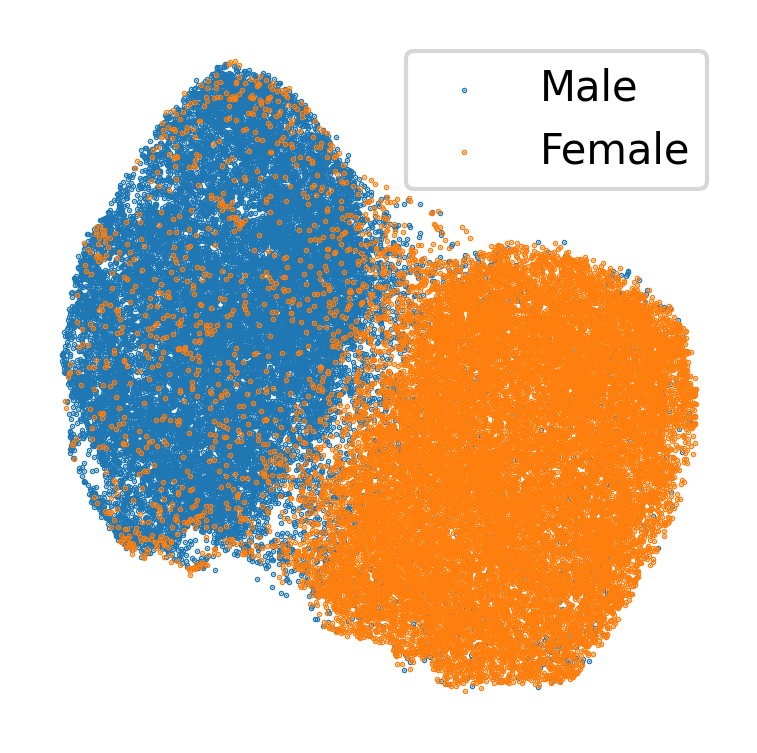

In [29]:
fig, ax = plt.subplots(figsize=(3,3), dpi=300)
ax.scatter(umapped[latent_df['Sex_Male_0_0'].to_numpy()==1,0], 
           umapped[latent_df['Sex_Male_0_0'].to_numpy()==1,1], s=.1, label='Male')
ax.scatter(umapped[latent_df['Sex_Male_0_0'].to_numpy()==0,0], 
           umapped[latent_df['Sex_Male_0_0'].to_numpy()==0,1], s=.1, label='Female')
ax.axis("off")
ax.legend()

In [ ]:
r2_thresh = 0.01
adjust_cols = ['Sex_Male_0_0']
new_cols, latent_df = iterative_subspace_removal(adjust_cols, latent_df, latent_cols, r2_thresh=r2_thresh)

Scores were {'Sex_Male_0_0': 0.7758}, remaining columns are ['Sex_Male_0_0']
After iteration 1 Space shape is: (44643, 255)
Scores were {'Sex_Male_0_0': 0.7755}, remaining columns are ['Sex_Male_0_0']
After iteration 2 Space shape is: (44643, 254)
Scores were {'Sex_Male_0_0': 0.7747}, remaining columns are ['Sex_Male_0_0']
After iteration 3 Space shape is: (44643, 253)
Scores were {'Sex_Male_0_0': 0.774}, remaining columns are ['Sex_Male_0_0']
After iteration 4 Space shape is: (44643, 252)
Scores were {'Sex_Male_0_0': 0.7736}, remaining columns are ['Sex_Male_0_0']
After iteration 5 Space shape is: (44643, 251)
Scores were {'Sex_Male_0_0': 0.773}, remaining columns are ['Sex_Male_0_0']
After iteration 6 Space shape is: (44643, 250)
Scores were {'Sex_Male_0_0': 0.772}, remaining columns are ['Sex_Male_0_0']
After iteration 7 Space shape is: (44643, 249)
Scores were {'Sex_Male_0_0': 0.7718}, remaining columns are ['Sex_Male_0_0']
After iteration 8 Space shape is: (44643, 248)
Scores were

In [ ]:
new_space = latent_df[new_cols].to_numpy()
umapped_debias = umap.UMAP().fit_transform(new_space)

In [ ]:
fig, ax = plt.subplots(figsize=(3,3), dpi=300)
ax.scatter(umapped_debias[latent_df['Sex_Male_0_0'].to_numpy()==1,0], 
           umapped_debias[latent_df['Sex_Male_0_0'].to_numpy()==1,1], s=.1, label='Male')
ax.scatter(umapped_debias[latent_df['Sex_Male_0_0'].to_numpy()==0,0], 
           umapped_debias[latent_df['Sex_Male_0_0'].to_numpy()==0,1], s=.1, label='Female')
ax.axis("off")
ax.legend()